<a href="https://colab.research.google.com/github/APaulalvarez/Data-Science-III-NLP-Deep-Learning-aplicado-a-Ciencia-de-Datos/blob/main/Final_Alvarez_Proyecto__NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <U>**Taller NLP**</U>
## **Data Science III: NLP & Deep Learning aplicado a Ciencia de Datos - Coderhouse**
### **_Alumna:_** Ana Paula Alvarez Pringles
### **_Comisión:_** 60960
### **_Porfesor:_**  Ignacio Russo Locati
### **_Tutor:_**  Mariano Rodas



## Resumen
Esta dataset fue descargado desde Kaggle y se corresponde con el paper de Malo et al. 2014.

El dataset contiene frases y fragmentos de noticias del ámbito financiero (columna 'text') y la polaridad de la misma desde la perspectiva del inversor pudiendo ser esta positiva, negativa o neutral (columna 'sentiment').



Malo, P., Sinha, A., Korhonen, P., Wallenius, J., & Takala, P. (2014). Good debt or bad debt: Detecting semantic orientations in economic texts. Journal of the Association for Information Science and Technology, 65(4), 782-796.

# Carga de dependencias

In [ ]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series


import nltk
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Acquisition y exploración

El data set fue obtenido desde el sitio https://www.kaggle.com


In [ ]:
dataset = files.upload()

Saving financial.csv to financial.csv


In [ ]:
df = pd.read_csv(io.BytesIO(dataset["financial.csv"]),encoding='latin1',names=['sentiment', 'text'], header=0)
df.head()

,sentiment,text
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Este dataset posee:
* ID - número identificatorio de cada instancia.
* Sentiment - asignación de polaridad "neutral", "positiva" o "negativa" asignada a cada sentencia.
* Text - fragmentos de noticias financieras.

In [ ]:
df.shape

(4845, 2)

Tenemos un total de 4845 frases del ámbito financiero.

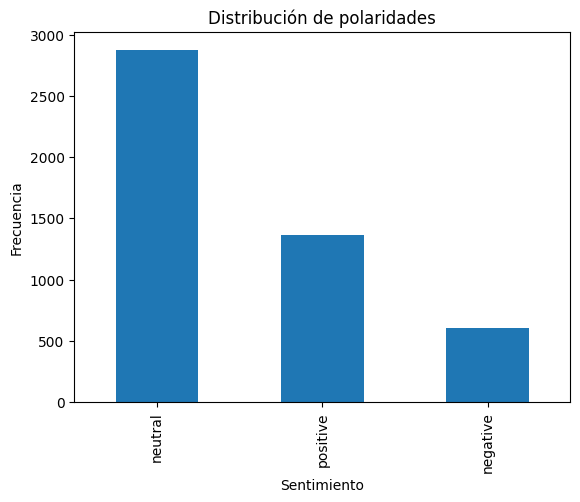

In [ ]:
# Conteo por tipo de sentimiento

df['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribución de polaridades')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

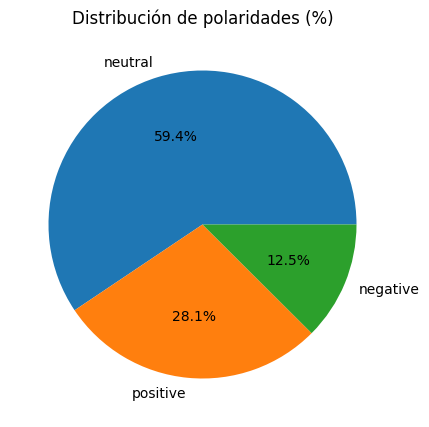

In [ ]:
label_counts: Series = df.sentiment.value_counts()
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%')
plt.title('Distribución de polaridades (%)')
plt.show()

De los 4845 frases el 59% (casi 2900) se consideran neutrales, el 28% positivas y tan solo el 12% (600 frases) negativas.

Este es un dataframe de clases desbalanceadas.

In [ ]:
#Exploramos la cantidad de caracteres de la variable "text".

max_length = df['text'].apply(len).max()
min_length = df['text'].apply(len).min()
avg_length = df['text'].apply(len).mean()

print(f"Longitud máxima: {max_length}")
print(f"Longitud mínima: {min_length}")
print(f"Longitud promedio: {avg_length}")

Longitud máxima: 315
Longitud mínima: 9
Longitud promedio: 128.13230134158925


In [ ]:
# Llama la atención esa instancia de longitud 9, vamos a ver que es.

min_length_index = df['text'].apply(len).idxmin()
texto_minimo = df.loc[min_length_index, 'text']

print(f"El texto con la longitud mínima es: {texto_minimo}")

El texto con la longitud mínima es: Welcome !


In [ ]:
#Vamos a ver el contenido y polaridad de otras frases cortas .

frases_cortas = df[df['text'].str.len() <= 20]
print(frases_cortas[['text','sentiment']])

                      text sentiment
1022     All are welcome .   neutral
1115             Welcome !   neutral
2568       Status : Agreed   neutral
2982           It 's not .   neutral
3039  ND = Not disclosed .   neutral
3060        NWC ANALYSIS :   neutral
3098          R&D Loan ) .   neutral
3449       What we think ?   neutral
3463   You 're not alone .   neutral


Vemos que estas frases cortas tienen poco contenido "económico" y todas son neutrales.

In [ ]:
# Chequeamos duplicados

print("Duplicates found:", df.text.duplicated().sum().sum())
duplicados = df[df.duplicated(subset=['text'], keep=False)]
print(duplicados)

Duplicates found: 8
     sentiment                                               text
77     neutral  TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
78    positive  TELECOMWORLDWIRE-7 April 2006-TJ Group Plc sel...
787   positive  The Group 's business is balanced by its broad...
788    neutral  The Group 's business is balanced by its broad...
1097   neutral  The issuer is solely responsible for the conte...
1098   neutral  The issuer is solely responsible for the conte...
1414   neutral  The report profiles 614 companies including ma...
1415   neutral  The report profiles 614 companies including ma...
2394   neutral  Ahlstrom 's share is quoted on the NASDAQ OMX ...
2395   neutral  Ahlstrom 's share is quoted on the NASDAQ OMX ...
2565   neutral  SSH Communications Security Corporation is hea...
2566   neutral  SSH Communications Security Corporation is hea...
3092   neutral  Proha Plc ( Euronext :7327 ) announced today (...
3093   neutral  Proha Plc ( Euronext :7327 ) announced t

In [ ]:
# Los eliminamos

df = df.drop_duplicates(subset=['text'], keep='first')
df.shape

(4837, 2)

# Text Preprocessing

In [ ]:
# Llevar todo el documento a minúscula para evitar la redundancia en la lista de tokens, una forma de normalizarlo.

df["text_lower"] = df["text"].str.lower()
df.head()

,sentiment,text,text_lower
0,neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...,the international electronic industry company ...
2,positive,With the new production plant the company woul...,with the new production plant the company woul...
3,positive,According to the company 's updated strategy f...,according to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing of aspocomp 's growth aspocomp is ag...


In [ ]:
# Remover caracteres especiales y números mediante una expresión regular.

df['text_clean'] = df['text_lower'].str.replace(r'[^a-záéíóúñü\s]+', '', regex=True)
df.head()

#### modifique la regex colocando el +, pero siguen quedando números en el ds.

,sentiment,text,text_lower,text_clean
0,neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...,the international electronic industry company ...,the international electronic industry company ...
2,positive,With the new production plant the company woul...,with the new production plant the company woul...,with the new production plant the company woul...
3,positive,According to the company 's updated strategy f...,according to the company 's updated strategy f...,according to the company s updated strategy fo...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing of aspocomp 's growth aspocomp is ag...,financing of aspocomp s growth aspocomp is agg...


In [ ]:
# Tokenización y eliminación de stopwords
# Desglosamos el texto en unidades más pequeñas que conformarán el corpus de palabras con las cuales el modelo aprenderá
# y luego removemos todas las palabras que no aportan sentido o informacion como conectores, articulos y preposiciones.

df['tokens'] = df['text_clean'].apply(word_tokenize)
stop_words = set(stopwords.words('english'))
df['tokens_sin_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df[['tokens', 'tokens_sin_stopwords']].head()

,tokens,tokens_sin_stopwords
0,"[technopolis, plans, to, develop, in, stages, ...","[technopolis, plans, develop, stages, area, le..."
1,"[the, international, electronic, industry, com...","[international, electronic, industry, company,..."
2,"[with, the, new, production, plant, the, compa...","[new, production, plant, company, would, incre..."
3,"[according, to, the, company, s, updated, stra...","[according, company, updated, strategy, years,..."
4,"[financing, of, aspocomp, s, growth, aspocomp,...","[financing, aspocomp, growth, aspocomp, aggres..."


Como vemos, removió las palabras: "to", "in", "the", "with", "of" entre otras.

In [ ]:
token_lengths = df['tokens'].apply(len)

max_length = token_lengths.max()
min_length = token_lengths.min()
avg_length = token_lengths.mean()

print(f"Número máximo de tokens por instancia: {max_length}")
print(f"Número mínimo de tokens por instancia: {min_length}")
print(f"Promedio de tokens por instancia: {avg_length}\n")

token_lengths_clean = df['tokens_sin_stopwords'].apply(len)

max_length_c = token_lengths_clean.max()
min_length_c = token_lengths_clean.min()
avg_length_c = token_lengths_clean.mean()

print(f"Número máximo de tokens sin stopwords por instancia: {max_length_c}")
print(f"Número mínimo de tokens sin stopwords por instancia: {min_length_c}")
print(f"Promedio de tokens sin stopwords por instancia: {avg_length_c}")

Número máximo de tokens por instancia: 50
Número mínimo de tokens por instancia: 1
Promedio de tokens por instancia: 19.308869133760595

Número máximo de tokens sin stopwords por instancia: 38
Número mínimo de tokens sin stopwords por instancia: 0
Promedio de tokens sin stopwords por instancia: 12.005788712011578


Podemos ver que la cantidad de palabras por frase disminuye luego de la remoción de stopwords, quedando como máximo 38 palabras y mínimo 12.

Seobserva que hau una instancia que pasa de tener 1 a 0 palabras. Vamos a explorar que es.

In [ ]:
min_length_index = df['tokens_sin_stopwords'].apply(len).idxmin()
fila = df.loc[[min_length_index]]
display(fila)

,sentiment,text,text_lower,text_clean,tokens,tokens_sin_stopwords
2982,neutral,It 's not .,it 's not .,it s not,"[it, s, not]",[]


Vemos que quedó vacia dado que todas eran stopwords. También podría eliminarse esa instancia.

In [ ]:
# Lematización
# En este paso buscamos reducir las palabras a su forma base.

nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    doc = nlp(' '.join(text))
    return [token.lemma_ for token in doc]

df['lemmas'] = df['tokens_sin_stopwords'].apply(lemmatize_text)

df[['tokens_sin_stopwords', 'lemmas']].head()


,tokens_sin_stopwords,lemmas
0,"[technopolis, plans, develop, stages, area, le...","[technopoli, plan, develop, stage, area, less,..."
1,"[international, electronic, industry, company,...","[international, electronic, industry, company,..."
2,"[new, production, plant, company, would, incre...","[new, production, plant, company, would, incre..."
3,"[according, company, updated, strategy, years,...","[accord, company, update, strategy, year, basw..."
4,"[financing, aspocomp, growth, aspocomp, aggres...","[finance, aspocomp, growth, aspocomp, aggressi..."


In [ ]:
df.head(15)

,sentiment,text,text_lower,text_clean,tokens,tokens_sin_stopwords,lemmas
0,neutral,Technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,technopolis plans to develop in stages an area...,"[technopolis, plans, to, develop, in, stages, ...","[technopolis, plans, develop, stages, area, le...","[technopoli, plan, develop, stage, area, less,..."
1,negative,The international electronic industry company ...,the international electronic industry company ...,the international electronic industry company ...,"[the, international, electronic, industry, com...","[international, electronic, industry, company,...","[international, electronic, industry, company,..."
2,positive,With the new production plant the company woul...,with the new production plant the company woul...,with the new production plant the company woul...,"[with, the, new, production, plant, the, compa...","[new, production, plant, company, would, incre...","[new, production, plant, company, would, incre..."
3,positive,According to the company 's updated strategy f...,according to the company 's updated strategy f...,according to the company s updated strategy fo...,"[according, to, the, company, s, updated, stra...","[according, company, updated, strategy, years,...","[accord, company, update, strategy, year, basw..."
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing of aspocomp 's growth aspocomp is ag...,financing of aspocomp s growth aspocomp is agg...,"[financing, of, aspocomp, s, growth, aspocomp,...","[financing, aspocomp, growth, aspocomp, aggres...","[finance, aspocomp, growth, aspocomp, aggressi..."
5,positive,"For the last quarter of 2010 , Componenta 's n...","for the last quarter of 2010 , componenta 's n...",for the last quarter of componenta s net sal...,"[for, the, last, quarter, of, componenta, s, n...","[last, quarter, componenta, net, sales, double...","[last, quarter, componenta, net, sale, double,..."
6,positive,"In the third quarter of 2010 , net sales incre...","in the third quarter of 2010 , net sales incre...",in the third quarter of net sales increased ...,"[in, the, third, quarter, of, net, sales, incr...","[third, quarter, net, sales, increased, eur, m...","[third, quarter, net, sale, increase, eur, mn,..."
7,positive,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose to eur 13.1 mn from eur ...,operating profit rose to eur mn from eur mn ...,"[operating, profit, rose, to, eur, mn, from, e...","[operating, profit, rose, eur, mn, eur, mn, co...","[operating, profit, rise, eur, mn, eur, mn, co..."
8,positive,"Operating profit totalled EUR 21.1 mn , up fro...","operating profit totalled eur 21.1 mn , up fro...",operating profit totalled eur mn up from eur...,"[operating, profit, totalled, eur, mn, up, fro...","[operating, profit, totalled, eur, mn, eur, mn...","[operate, profit, total, eur, mn, eur, mn, rep..."
9,positive,TeliaSonera TLSN said the offer is in line wit...,teliasonera tlsn said the offer is in line wit...,teliasonera tlsn said the offer is in line wit...,"[teliasonera, tlsn, said, the, offer, is, in, ...","[teliasonera, tlsn, said, offer, line, strateg...","[teliasonera, tlsn, say, offer, line, strategy..."


Acá podemos observar por ejemplo, en las instancias 7 y 8 que la palabra "operating" fue lematizada como "operate" correctamente, mientras que en la otra la proceso sin cambio, al igual que en la número 12.

In [ ]:
#Stemming
# En este paso buscamos quedarnos con la raiz de cada palabra, sin necesidad de que esa forma reducida exista.
stemmer = SnowballStemmer('english')
df['stems'] = df['tokens_sin_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])

df[['tokens_sin_stopwords', 'stems']].head()

,tokens_sin_stopwords,stems
0,"[technopolis, plans, develop, stages, area, le...","[technopoli, plan, develop, stage, area, less,..."
1,"[international, electronic, industry, company,...","[intern, electron, industri, compani, elcoteq,..."
2,"[new, production, plant, company, would, incre...","[new, product, plant, compani, would, increas,..."
3,"[according, company, updated, strategy, years,...","[accord, compani, updat, strategi, year, baswa..."
4,"[financing, aspocomp, growth, aspocomp, aggres...","[financ, aspocomp, growth, aspocomp, aggress, ..."


In [ ]:
# TF-IDF
# Aplicamos
# Unimos las palabras lematizadas
df['lemmas_str'] = df['lemmas'].apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer(max_features=500, stop_words=stopwords.words('english'))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmas_str'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_df.head()

,ab,accord,account,acquire,acquisition,activity,add,addition,adp,afx,...,well,whole,work,world,worth,would,year,yearonyear,yesterday,yit
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.339967,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.423417,0.000000,0.0,0.0,0.0
3,0.0,0.233623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.185147,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


Para mayor simplicidad se pidieron solo las 500 lemmas más relevantes de un total de 58000.

Como solo muestra algunas instancias, le pedimos los que mayor valor del classifier tengan y que los ordene de forma descendiente.

In [ ]:
max_tfidf_per_lemma = tfidf_df.max()
sorted_lemmas = max_tfidf_per_lemma.sort_values(ascending=False)
n = 300
print(sorted_lemmas.head(n))

long            1.000000
company         1.000000
include         1.000000
enter           1.000000
july            1.000000
                  ...   
yearonyear      0.709108
term            0.708679
segment         0.708532
subscription    0.708132
world           0.707194
Length: 300, dtype: float64


Vemos que 300 de estas 500 palabras tienen valores de 0.7 o más, indicando que son palabras muy relevantes en los fragmentos donde aparecen, pudiendo ser de utilidad para el entrenamiento del modelo y su posterior aplicación en clasificar nuevas frases que utilicen esas palabras segun su polaridad.

In [ ]:
# Ahora probaremmos identificar las palabras más representativas para las frases positivas y negativas.

positivas = df[df['sentiment'] == 'positive']
negativas = df[df['sentiment'] == 'negative']
neutrales = df[df['sentiment'] == 'neutral']

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k,k),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

mn corresponding period 31
profit rose eur 27
mn eur mn 25
mln euro mln 23
eur mn eur 22
operating profit rose 21
month period increased 19
net profit rose 18
period increased respectively 16
said today net 16
corresponding period 2005 15
corresponding period 2006 14
compared corresponding period 14
net sales increased 13
corresponding period 2009 13
earnings share eps 13
net loss narrowed 13
eur mn corresponding 12
second quarter 2010 12
operating profit net 11


<Axes: title={'center': 'Trigramas más comunes en frases positivas'}, xlabel='words'>

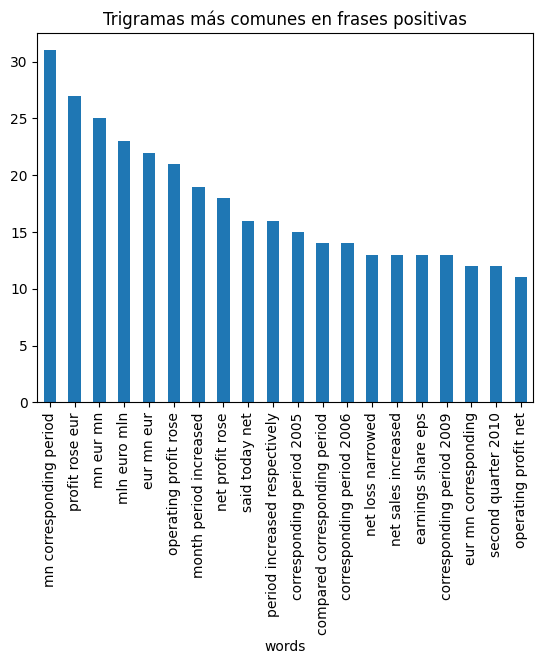

In [ ]:
# frases positivas
common_words = get_top_n_words(positivas['text'], 20, 3)
for word, freq in common_words:
    print(word, freq)

df_pos = pd.DataFrame(common_words, columns=['words', 'count'])
df_pos.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Trigramas más comunes en frases positivas'
)

mn corresponding period 23
profit eur mn 21
eur mn eur 20
compared profit eur 17
eur mn compared 17
mn eur mn 16
totalled eur mn 15
non recurring items 14
mln euro mln 13
eur mn corresponding 13
mn compared profit 12
totaled eur mn 12
corresponding period 2008 11
earnings share eps 11
excluding non recurring 11
said today net 10
mn compared eur 10
loss totalled eur 10
eur mn quarter 10
mn second quarter 10


<Axes: title={'center': 'Trigramas más comunes en frases negativas'}, xlabel='words'>

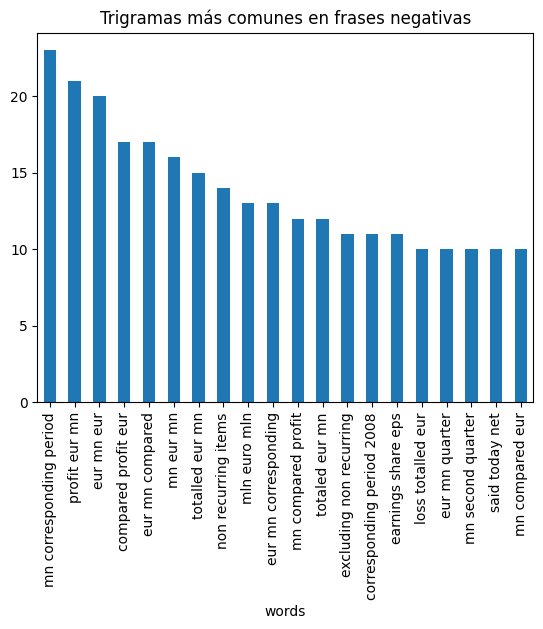

In [ ]:
# frases negativas
common_words = get_top_n_words(negativas['text'], 20, 3)
for word, freq in common_words:
    print(word, freq)

df_neg = pd.DataFrame(common_words, columns=['words', 'count'])
df_neg.groupby('words').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Trigramas más comunes en frases negativas'
)

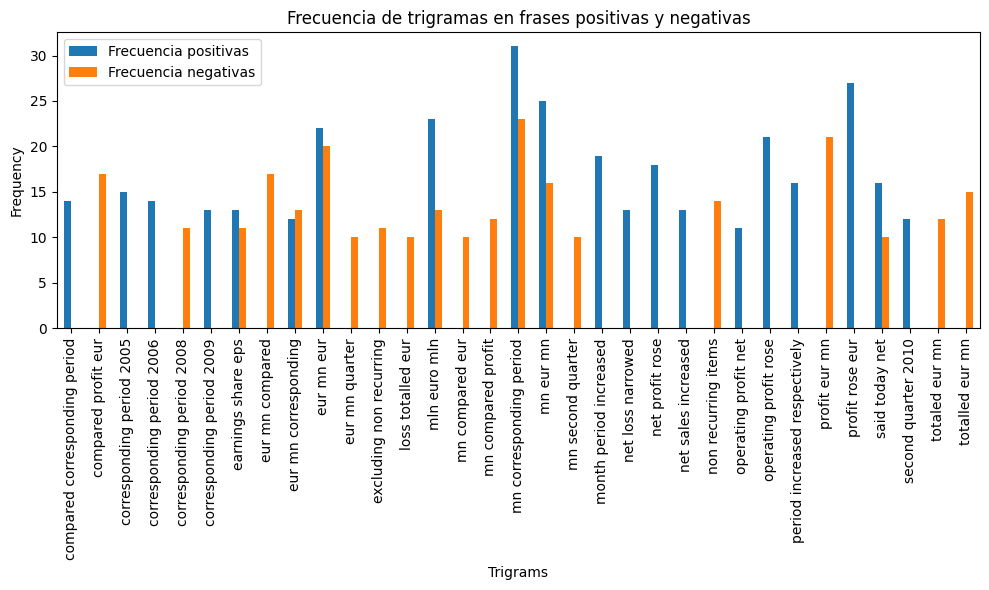

In [ ]:
# Extract trigrams for positive and negative sentiments
positive_trigrams = get_top_n_words(positivas['text'], 20, 3)
negative_trigrams = get_top_n_words(negativas['text'], 20, 3)

# Create DataFrames
positive_df = pd.DataFrame(positive_trigrams, columns=['trigram', 'positive_freq'])
negative_df = pd.DataFrame(negative_trigrams, columns=['trigram', 'negative_freq'])

# Merge DataFrames
combined_df = pd.merge(positive_df, negative_df, on='trigram', how='outer').fillna(0)
combined_df = combined_df.rename(columns={'positive_freq': 'Frecuencia positivas', 'negative_freq': 'Frecuencia negativas'})

# Visualize
combined_df.plot(x='trigram', y=['Frecuencia positivas', 'Frecuencia negativas'], kind='bar', figsize=(10, 6))
plt.title('Frecuencia de trigramas en frases positivas y negativas')
plt.xlabel('Trigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

In [ ]:
# Aplicamos pos tagging sobre los lemmas para ver que tipo de palabras son las más frecuentes.

nlp = spacy.load("en_core_web_sm")
def pos_tagg(text):
    text = " ".join(text)
    doc = nlp(text)
    tokens = [(token.text, token.tag_, token.pos_, spacy.explain(token.tag_)) for token in doc]
    return tokens
df['nlp_data'] = df['lemmas'].apply(pos_tagg)

In [ ]:
from collections import defaultdict

# Cuantas etiquetas únicas de cada tipo hay
tag_counts = defaultdict(int)
for row in df['nlp_data']:
    for token_data in row:
        tag = token_data[2]
        tag_counts[tag] += 1

# número de diferentes tipos de etiquetas
num_unique_tags = len(tag_counts)

print(f"Diferentes tipos de etiquetas en el texto: {num_unique_tags}\n")

for tag, count in tag_counts.items():
  print(f"{tag}: {count}")

Diferentes tipos de etiquetas en el texto: 17

NOUN: 27671
VERB: 6423
ADV: 1537
ADJ: 7141
NUM: 890
PROPN: 13278
AUX: 223
CCONJ: 15
ADP: 477
INTJ: 70
PRON: 82
SCONJ: 83
X: 128
PART: 15
DET: 40
PUNCT: 7
SYM: 1


In [ ]:
# Nos quedaremos con los sustantivos, vervos, advervios y adjetivos.
# No supe como ejecutarlo pero la idea sería si podría conformar mi corpues solo con estas categorías de palabras.

#Modelado

In [ ]:
# Nos quedaremos solo con las frases positivas y negativas, para entrenar un modelo de clasificación binaria.
# descartamos frases neutrales y binarizamos a 0 = negativas y 1 = positivas.

df_binario = df[df['sentiment'] != 'neutral']
df_binario['sentiment_binario'] = df_binario['sentiment'].map({'negative': 0, 'positive': 1})
df_binario = df_binario.drop('sentiment', axis=1)

<ipython-input-24-f9790039a2e9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binario['sentiment_binario'] = df_binario['sentiment'].map({'negative': 0, 'positive': 1})


In [ ]:
df_binario = df_binario[['text', 'sentiment_binario']].copy()  #esta línea creo está de más
df_binario.head()

,text,sentiment_binario
1,The international electronic industry company ...,0
2,With the new production plant the company woul...,1
3,According to the company 's updated strategy f...,1
4,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,1
5,"For the last quarter of 2010 , Componenta 's n...",1


## Análisis de sentimiento utilizando bag of words.

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Get standard stop words
stop_words = set(stopwords.words('english'))

# 2. Tokenize stop words and add new tokens to the set
extra_tokens = set(word for word in word_tokenize(' '.join(stop_words)))
stop_words.update(extra_tokens)

# 3. (Optional) Remove specific tokens if needed
stop_words.discard("n't")
stop_words.discard("'")
stop_words_list = list(stop_words)


In [ ]:
# Automatizamos el preprocesamiento

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Definir una función de lematización

def lemmatize_text(text):
   doc = nlp(' '.join(text))
   return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Crear el vectorizador con la función de lematización

bow_counts = CountVectorizer(
    preprocessor=lemmatize_text,
    lowercase=True,
    token_pattern=r'[^a-záéíóúñü\s]+',
    stop_words=stop_words_list,
    ngram_range=(1, 1),
)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
#Separo mi dataset para entrenamiento y testeo
from sklearn.model_selection import train_test_split

df_binario_train, df_binario_test = train_test_split(df_binario, test_size=0.2, random_state=0)

In [ ]:
#Aplicamos el preprocesamiento          ##  no logro eliminar el "'" del warning

X_train_bow = bow_counts.fit_transform(df_binario_train.text)
X_test_bow = bow_counts.transform(df_binario_test.text)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  warnings.warn(


In [ ]:
# Separo la variable target del resto de los datos

y_train_bow = df_binario_train['sentiment_binario']
y_test_bow = df_binario_test['sentiment_binario']

In [ ]:
# Chequeamos la distribución de las clases en testeo
# 0 = negativas y 1 = positivas

y_test_bow.value_counts() / y_test_bow.shape[0]

,count
sentiment_binario,
1,0.713198
0,0.286802


Los datos de prueba contienen 71% de frases positivas, para tener como linea de base y evaluar la mejora en las métricas en los distintos modelos.

### Random forest (Ensamble Bagging)

F1 Score sobre el set de entrenamiento: 0.8152337858220211 

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       491
           1       0.69      1.00      0.82      1081

    accuracy                           0.69      1572
   macro avg       0.84      0.50      0.41      1572
weighted avg       0.79      0.69      0.56      1572



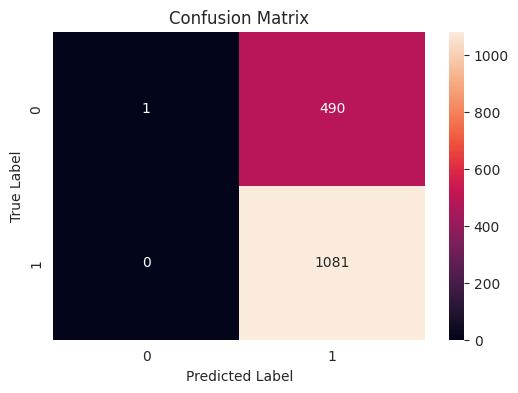

F1 Score sobre el set de testeo: 0.8325925925925926 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.71      1.00      0.83       281

    accuracy                           0.71       394
   macro avg       0.36      0.50      0.42       394
weighted avg       0.51      0.71      0.59       394



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


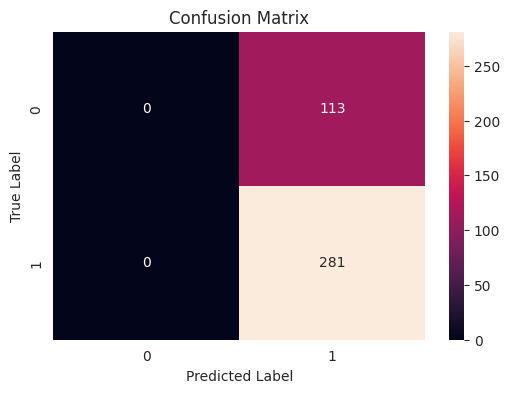

In [ ]:
# Elegimos el F1 score dado el balance de Falsos positivos y falsos negativos que aporta esta métrica
# y que resulta útil en este caso, que dependiendo de la aplicación que le demos, nos interesará más disminuir unos u otros.

# Entrenar el arbol
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=6, n_estimators=100)
rf.fit(X_train_bow, y_train_bow)

# Obtenemos las predicciones del modelo
preds_rf = rf.predict(X_test_bow)
preds_train_rf = rf.predict(X_train_bow)


from sklearn.metrics import confusion_matrix
from sklearn import metrics
sns.set_style('darkgrid')

# TRAIN---------------------------------------------------
# F1 Score
train_accuracy = metrics.f1_score(y_train_bow, preds_train_rf)
print('F1 Score sobre el set de entrenamiento:', train_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_train_bow, preds_train_rf))
#---------------------------------------------------
# Creando la matriz de confusión
cm_train_rf = confusion_matrix(y_train_bow, preds_train_rf)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# TEST---------------------------------------------------
# F1 Score
test_accuracy = metrics.f1_score(y_test_bow, preds_rf)
print('F1 Score sobre el set de testeo:', test_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_test_bow, preds_rf))
#---------------------------------------------------
# Creando la matriz de confusión
cm_test_rf= confusion_matrix(y_test_bow, preds_rf)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#Clase 1: Positiva
#Clase 0: Negativa

Asumo que por el desbalanceo de clases, el modelo esta prediciendo todo como 1.

Aunque tal vez también puede ser por no tener palabras tan específicas de las frases negativas o positivas, como vimos en los graficos de n-grams.

Probamos modificar esto.

In [ ]:
# Automatizamos el preprocesamiento

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Definir una función de lematización

def lemmatize_text(text):
   doc = nlp(' '.join(text))
   return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Crear el vectorizador con la función de lematización

bow_counts = CountVectorizer(
    preprocessor=lemmatize_text,
    lowercase=True,
    token_pattern=r'[^a-záéíóúñü\s]+',
    stop_words=stopwords.words('english'),
    ngram_range=(1, 4),                       ### CAMBIAMOS ESTO
)

#Aplicamos el preprocesamiento

X_train_bow = bow_counts.fit_transform(df_binario_train.text)
X_test_bow = bow_counts.transform(df_binario_test.text)

# Separo la variable target del resto de los datos

y_train_bow = df_binario_train['sentiment_binario']
y_test_bow = df_binario_test['sentiment_binario']



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'"] not in stop_words.
  warnings.warn(


F1 Score sobre el set de entrenamiento: 0.814926498303807 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       491
           1       0.69      1.00      0.81      1081

    accuracy                           0.69      1572
   macro avg       0.34      0.50      0.41      1572
weighted avg       0.47      0.69      0.56      1572



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


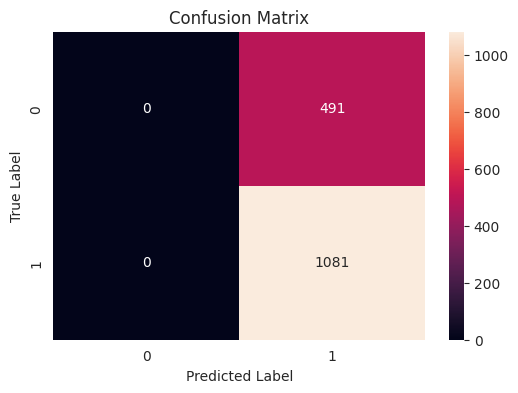

F1 Score sobre el set de testeo: 0.8325925925925926 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.71      1.00      0.83       281

    accuracy                           0.71       394
   macro avg       0.36      0.50      0.42       394
weighted avg       0.51      0.71      0.59       394



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


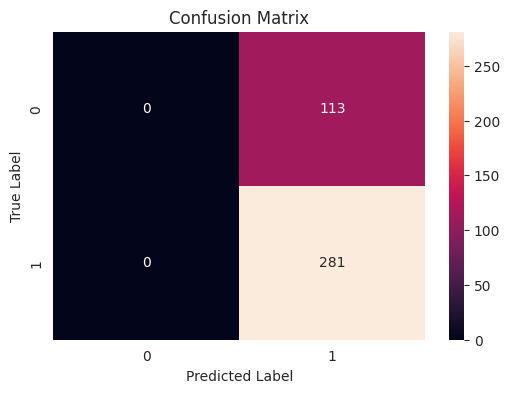

In [ ]:
# Entrenar el arbol
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=6, n_estimators=100)
rf.fit(X_train_bow, y_train_bow)

# Obtenemos las predicciones del modelo
preds_rf = rf.predict(X_test_bow)
preds_train_rf = rf.predict(X_train_bow)


from sklearn.metrics import confusion_matrix
from sklearn import metrics
sns.set_style('darkgrid')

# TRAIN---------------------------------------------------
# F1 Score
train_accuracy = metrics.f1_score(y_train_bow, preds_train_rf)
print('F1 Score sobre el set de entrenamiento:', train_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_train_bow, preds_train_rf))
#---------------------------------------------------
# Creando la matriz de confusión
cm_train_rf = confusion_matrix(y_train_bow, preds_train_rf)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# TEST---------------------------------------------------
# F1 Score
test_accuracy = metrics.f1_score(y_test_bow, preds_rf)
print('F1 Score sobre el set de testeo:', test_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_test_bow, preds_rf))
#---------------------------------------------------
# Creando la matriz de confusión
cm_test_rf= confusion_matrix(y_test_bow, preds_rf)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#Clase 1: Positiva
#Clase 0: Negativa

In [ ]:
feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index=bow_counts.get_feature_names_out(),
    columns=['importance']
)
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
2008,0.040275
T,0.031546
2007,0.027704
25,0.026125
2009,0.020837
EUR,0.018728
UPM,0.017048
",",0.016563
R,0.014691
``,0.013190


No hay modificación alguna. Y al ver las palabras que más efecto tuvieorn en el desempeño del modelo vemos que hay varios números que a pesar de modificar la regex no se eliminaron y letras sueltas que tal vez son resultado de pasos erroneos dentro del cunt vectorizer, ya que es distinto a hacer el prerpocesamiento paso a paso.

De no llegar a este resultado, de todos modos hubiesemos intentado mejorar el modelo tuneando hiperparámetro por ejemplo.

Tal vez para este problema mejor probar con otro tipo de modelo.

## TF-IDF

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 1. Get standard stop words
stop_words = set(stopwords.words('english'))

# 2. Tokenize stop words and add new tokens to the set
extra_tokens = set(word for word in word_tokenize(' '.join(stop_words)))
stop_words.update(extra_tokens)

# 3. (Optional) Remove specific tokens if needed
stop_words.discard("n't")
stop_words.discard("'")
stop_words_list = list(stop_words)


In [ ]:
# Vectorizador
tfidf_counts = TfidfVectorizer(
    tokenizer=word_tokenize,
    stop_words=stopwords.words('english'),
    ngram_range=(1,1)
)

X_train_tfidf = tfidf_counts.fit_transform(df_binario_train.text)
X_test_tfidf = tfidf_counts.transform(df_binario_test.text)

NameError: name 'df_binario_train' is not defined

In [ ]:
X_train_tfidf.head()

NameError: name 'X_train_tfidf' is not defined

### Random forest

F1 Score sobre el set de entrenamiento: 0.8152337858220211 

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       491
           1       0.69      1.00      0.82      1081

    accuracy                           0.69      1572
   macro avg       0.84      0.50      0.41      1572
weighted avg       0.79      0.69      0.56      1572



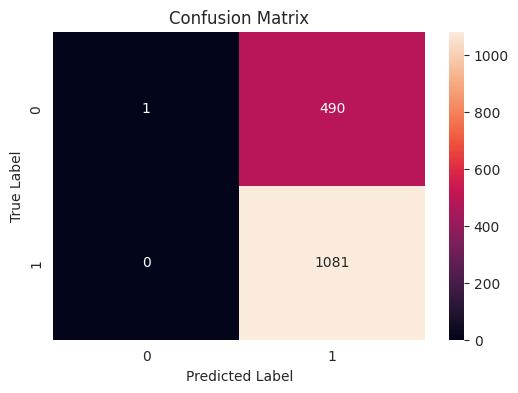

F1 Score sobre el set de testeo: 0.8325925925925926 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.71      1.00      0.83       281

    accuracy                           0.71       394
   macro avg       0.36      0.50      0.42       394
weighted avg       0.51      0.71      0.59       394



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


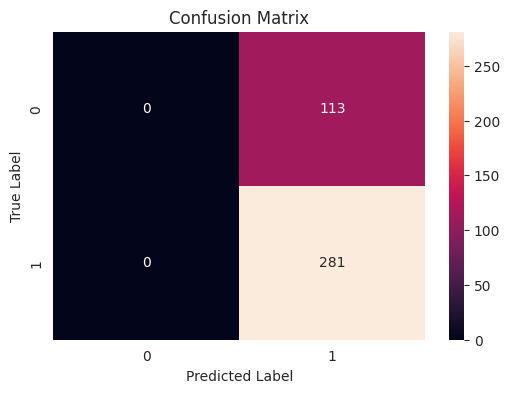

In [ ]:
# Entrenar el arbol
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=6, n_estimators=100)
rf.fit(X_train_tfidf, y_train_bow)

# Obtenemos las predicciones del modelo
preds_rf = rf.predict(X_test_tfidf)
preds_train_rf = rf.predict(X_train_tfidf)


from sklearn.metrics import confusion_matrix
from sklearn import metrics
sns.set_style('darkgrid')

# TRAIN---------------------------------------------------
# F1 Score
train_accuracy = metrics.f1_score(y_train_bow, preds_train_rf)
print('F1 Score sobre el set de entrenamiento:', train_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_train_bow, preds_train_rf))
#---------------------------------------------------
# Creando la matriz de confusión
cm_train_rf = confusion_matrix(y_train_bow, preds_train_rf)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# TEST---------------------------------------------------
# F1 Score
test_accuracy = metrics.f1_score(y_test_bow, preds_rf)
print('F1 Score sobre el set de testeo:', test_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_test_bow, preds_rf))
#---------------------------------------------------
# Creando la matriz de confusión
cm_test_rf= confusion_matrix(y_test_bow, preds_rf)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#Clase 1: Positiva
#Clase 0: Negativa

In [ ]:
feature_importances = pd.DataFrame(
    rf.feature_importances_,
    index=tfidf_counts.get_feature_names_out(),
    columns=['importance']
)
feature_importances.sort_values(['importance'], ascending=False)[:10]

,importance
fell,0.032976
decreased,0.032332
lower,0.022373
2008,0.021889
profit,0.018773
increase,0.018433
temporarily,0.017780
period,0.016936
staff,0.016182
half,0.016171


Acá si encontramos que las palabras que definen el modelo son palabras reales (salvo por un número).

### Regresión logística


In [ ]:
from sklearn.linear_model import LogisticRegression

# definiendo la clase del modelo
lr_model_tf_idf = LogisticRegression(solver="liblinear", penalty='l1', C=10)

# Entrenar
lr_model_tf_idf.fit(X_train_tfidf, y_train_bow)

# Predecir
test_pred_lr_prob = lr_model_tf_idf.predict_proba(X_test_tfidf)
test_pred_lr_all = lr_model_tf_idf.predict(X_test_tfidf)

# Evaluar el modelo
print("F1 score: ",f1_score(y_test_bow, test_pred_lr_all))

F1 score:  0.8834782608695653


F1 Score sobre el set de entrenamiento: 0.8152337858220211 

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       491
           1       0.69      1.00      0.82      1081

    accuracy                           0.69      1572
   macro avg       0.84      0.50      0.41      1572
weighted avg       0.79      0.69      0.56      1572



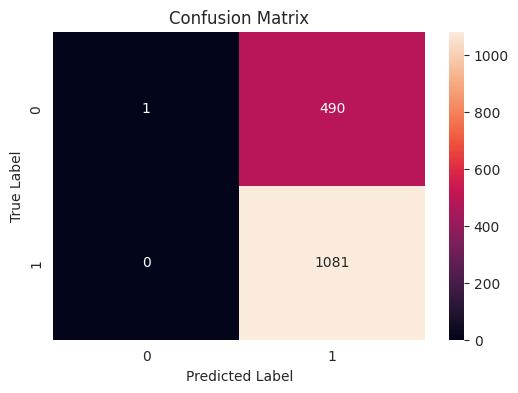

F1 Score sobre el set de testeo: 0.8325925925925926 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       113
           1       0.71      1.00      0.83       281

    accuracy                           0.71       394
   macro avg       0.36      0.50      0.42       394
weighted avg       0.51      0.71      0.59       394



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


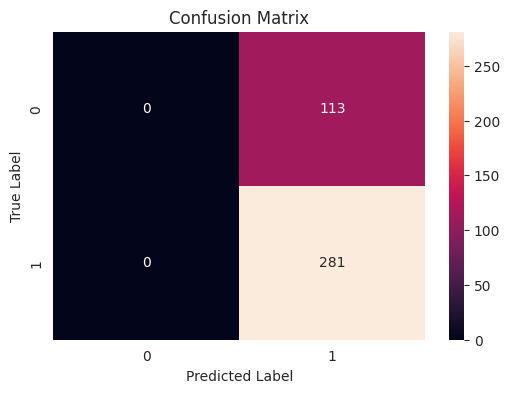

In [ ]:
from sklearn.linear_model import LogisticRegression

rl = RandomForestClassifier(max_depth=6, n_estimators=100)
rl.fit(X_train_tfidf, y_train_bow)

# Obtenemos las predicciones del modelo
preds_rl = rl.predict(X_test_tfidf)
preds_train_rl = rl.predict(X_train_tfidf)


from sklearn.metrics import confusion_matrix
from sklearn import metrics
sns.set_style('darkgrid')

# TRAIN---------------------------------------------------
# F1 Score
train_accuracy = metrics.f1_score(y_train_bow, preds_train_rl)
print('F1 Score sobre el set de entrenamiento:', train_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_train_bow, preds_train_rl))
#---------------------------------------------------
# Creando la matriz de confusión
cm_train_rl = confusion_matrix(y_train_bow, preds_train_rl)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# TEST---------------------------------------------------
# F1 Score
test_accuracy = metrics.f1_score(y_test_bow, preds_rl)
print('F1 Score sobre el set de testeo:', test_accuracy, '\n')
#---------------------------------------------------
# Classification report.
print(metrics.classification_report(y_test_bow, preds_rl))
#---------------------------------------------------
# Creando la matriz de confusión
cm_test_rl= confusion_matrix(y_test_bow, preds_rl)

# usando heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test_rf, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
#Clase 1: Positiva
#Clase 0: Negativa

Aunque cambie de modelo algo esta dando fuera de lo esperado, creo que es en parte por  el preprocesamiento y por otra gran parte el desbalance de clases.

**Proyecciones**:

Respecto al modelado de este data set probaría si hay diferencias en el rendimiento con y sin stopwords, ya que son en general frases no tan largas, en donde a veces el uso de estas palabras podría tener influencia en la determinación de la polaridad.

Además, durante el preprocesamiento a pesar de modificar la regex el texto permaneció con caracteres numéricos que probaría sacar y evaluar si modifica las métricas finales.

Por último, las clases "positivas" y "negativas" se encontraban desbalanceadas. No utilice ningún método visto en el modulo dos (SMOTE, RandomOverSampler, SmoteTomek) dado que no me convencía el hecho de generar datos sínteticos en este caso de estar trabajando con texto.

Se podría probrar además cambiando el ngrams para utilizar esas asociaciones entre palabras.